# Imports and Preprocessing

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE


pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
#nltk.download('averaged_perceptron_tagger')

In [5]:
#nltk.download('wordnet')

In [6]:
#conda install -c conda-forge imbalanced-learn

In [7]:
df = pd.read_csv("./Data/clean_tweets.csv", index_col=0)
df.head(2)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,2.0


In [8]:
df.target.value_counts(normalize=True)

0.0    0.602954
2.0    0.333259
1.0    0.063787
Name: target, dtype: float64

Filling null brand values with a string for possible future analysis.

In [9]:
df.brand.fillna(value="missing").value_counts(normalize=True)

missing    0.632722
Apple      0.268800
Google     0.098478
Name: brand, dtype: float64

Creating a dataframe with only positive or negative tags.

In [10]:
binary_df = df.loc[df.target != 0].copy()

In [11]:
binary_df.target.value_counts(normalize=True)

2.0    0.839346
1.0    0.160654
Name: target, dtype: float64

Changing tags to 0 (positive) and 1 (negative).

In [12]:
binary_df['target'] = binary_df['target'].apply(lambda x: 0 if x == 2 else x)

Defining a function to add wordnet parts of speech to tokens.

In [13]:
### get_wordnet_pos was taken from Lecture 51-nlp_modeling.ipynb 
### link to the lecture: https://github.com/dvdhartsman/NTL-DS-080723/blob/main/4phase/51-nlp_modeling.ipynb


def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def preprocess(tweet):
    """
    This is a function that is intended to handle all of the tokenization, lemmatization, and other
    preprocessing for our tweet data. It will make use of objects from other libraries, and will return
    a complete list of tokens that are ready to be vectorized into numerical data.
    """
    
    # Create a list of stopwords to be removed from our tokenized word list
    stops = stopwords.words("english")
    # Add punctuation to the list of stopwords
    stops += string.punctuation
    # Providing a regex pattern for the tokenizer to handle
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    # Instantiating a tokenizer
    tokenizer = RegexpTokenizer(pattern)
    # Creating a list of raw tokens
    raw_tokens = tokenizer.tokenize(tweet)
    # Using a comprehension to lower case every token
    lower_tokens = [i.lower() for i in raw_tokens]
    # Remove the stopwords from the list of tokens
    stopped_words = [i for i in lower_tokens if i not in stops]
    # Remove numerals from the list of tokens
    no_nums = [i.translate(str.maketrans('','', '0123456789')) for i in stopped_words]
    # Adding parts of speech to prepare for Lemmatization
    
    # This is the initial method to get parts of speech
    stopped_words = pos_tag(stopped_words)
    
    # Get_wordnet_pos() is the function to modify the pos definitions/assignments, creates tuples of (<word>, <pos>)
    stopped_words = [(word[0], get_wordnet_pos(word[1])) for word in stopped_words]
    
    lemmatizer = WordNetLemmatizer() 
    
    # This corrects the parts of speech and maximizes the usefulness of the lemmatization!!!!!
    document = [lemmatizer.lemmatize(word[0], word[1]) for word in stopped_words]
    
    # Re-join the list of cleaned tokens
    cleaned_doc = " ".join(document)
    return cleaned_doc
    

Defining a function to remove stopwords and punctuation and then tokenize tweets.

In [14]:
def preprocess(tweet):
    """
    This is a function that is intended to handle all of the tokenization, lemmatization, and other
    preprocessing for our tweet data. It will make use of objects from other libraries, and will return
    a complete list of tokens that are ready to be vectorized into numerical data.
    """
    
    # Create a list of stopwords to be removed from our tokenized word list
    stops = stopwords.words("english")
    # Add punctuation to the list of stopwords
    stops += string.punctuation
    # Providing a regex pattern for the tokenizer to handle
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    # Instantiating a tokenizer
    tokenizer = RegexpTokenizer(pattern)
    # Creating a list of raw tokens
    raw_tokens = tokenizer.tokenize(tweet)
    # Using a comprehension to lower case every token
    lower_tokens = [i.lower() for i in raw_tokens]
    # Remove the stopwords from the list of tokens
    stopped_words = [i for i in lower_tokens if i not in stops]
    
    # Adding parts of speech to prepare for Lemmatization
    
    # This is the initial method to get parts of speech
    stopped_words = pos_tag(stopped_words)
    
    # Get_wordnet_pos() is the function to modify the pos definitions/assignments, creates tuples of (<word>, <pos>)
    stopped_words = [(word[0], get_wordnet_pos(word[1])) for word in stopped_words]
    
    lemmatizer = WordNetLemmatizer() 
    
    # This corrects the parts of speech and maximizes the usefulness of the lemmatization!!!!!
    document = [lemmatizer.lemmatize(word[0], word[1]) for word in stopped_words]
    
    # Re-join the list of cleaned tokens
    cleaned_doc = " ".join(document)
    return cleaned_doc
    

Creating a class to process data faster.

In [15]:
# Creating the class that will store my data 

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, vectorizer, X_train, X_test, y_train, y_test):
        self.name = name
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = vectorizer.fit_transform(X_train)
        self.X_test = vectorizer.transform(X_test)
        self.y_train = y_train
        self.y_test = y_test
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        self.y_pred = self.model.predict(self.X_test)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss, "AUC":self.auc}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
        
        # Confusion Matrix Plot -> currently in init method
        fig, ax = plt.subplots(figsize=(7,7))
        self.cm = ConfusionMatrixDisplay.from_estimator(\
                                self.model, X=self.X_test, y=self.y_test, ax=ax)
        plt.title("Confusion Matrix for Test Data");
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        fig, ax = plt.subplots(figsize=(7,7))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr)
        ax.set_title(f"{self.name} ROC Curve");
    
    
    def __repr__(self):
      return f"Model name: ({self.model})"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

Applying the preprocess function to the tweets to create a token column.

In [16]:
binary_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand,tweet_clean,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,I have a 3G iPhone After 3 hrs tweeting at RIS...,1.0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Know about Awesome iPad iPhone app that you ll...,0.0
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,Can not wait for iPad 2 also They should sale ...,0.0
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,I hope this year s festival isn t as crashy as...,1.0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,great stuff on Fri SXSW Marissa Mayer Google T...,0.0


In [17]:
binary_df['tokens'] = binary_df['tweet_text'].apply(preprocess)

In [18]:
binary_df['tokens'][0]

'wesley g iphone hr tweet rise austin dead need upgrade plugin station sxsw'

In [19]:
binary_df['tweet_text'][0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [20]:
# 1 is a negative experience
binary_df['target'][0]

1.0

# Building Models

In [21]:
# Assign the proper values to our X and y variables
X = binary_df['tokens']
y = binary_df['target']

In [22]:
# Train test split on the data, stratifying because of the relative imbalance of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [23]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer()
Xt_tfidf = tfidf.fit_transform(X_train)

In [24]:
# Cell takes a couple minutes to run
df_tfidf = pd.DataFrame(Xt_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [25]:
dummy = DummyClassifier(strategy="most_frequent")

In [26]:
dummy.fit(Xt_tfidf, y_train)

DummyClassifier(strategy='most_frequent')

In [27]:
dummy.score(Xt_tfidf, y_train)

0.8391582111987974

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.5s finished


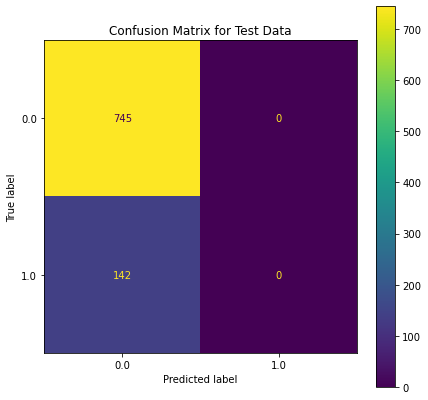

In [28]:
dummy_0 = Model("Dummy", dummy, tfidf, X_train, X_test, y_train, y_test)

In [29]:
mnb = MultinomialNB()

In [30]:
mnb.fit(Xt_tfidf, y_train)

MultinomialNB()

In [31]:
# Scores on training data
mnb.score(Xt_tfidf, y_train)

0.8575723412251034

In [32]:
# Test the predictions on test data
y_preds = mnb.predict(tfidf.transform(X_test))
accuracy_score(y_test, y_preds)

0.8455467869222097

In [33]:
cross_validate(mnb, Xt_tfidf, y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00200033, 0.00100017, 0.0010004 , 0.00199986, 0.00200796]),
 'score_time': array([0.00450134, 0.00550318, 0.00450277, 0.00551128, 0.00400162]),
 'test_precision': array([1., 1., 1., 1., 1.]),
 'test_accuracy': array([0.84615385, 0.84962406, 0.84398496, 0.84398496, 0.84586466]),
 'test_recall': array([0.04651163, 0.05882353, 0.02352941, 0.03488372, 0.04651163]),
 'test_f1': array([0.08888889, 0.11111111, 0.04597701, 0.06741573, 0.08888889]),
 'test_neg_log_loss': array([-0.38521923, -0.3714225 , -0.38615195, -0.38585453, -0.42158848])}

In [34]:
pd.Series(mnb.predict(tfidf.transform(X_test))).value_counts(), "True Values:", "*" * 60, y_test.value_counts()

(0.0    882
 1.0      5
 dtype: int64,
 'True Values:',
 '************************************************************',
 0.0    745
 1.0    142
 Name: target, dtype: int64)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
C:\Users\rchag\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


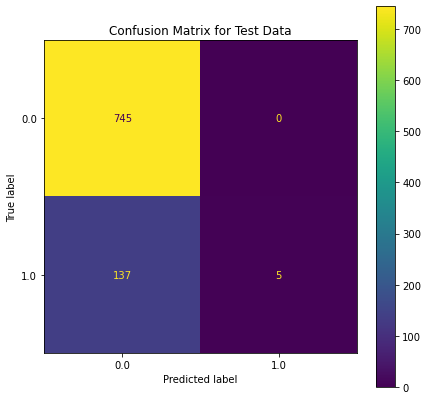

In [35]:
# I am receiving a warning about predictions not summing to 1, but everything seems to be working ok
mnb1 = Model("Naive Bayes 1", mnb, tfidf, X_train, X_test, y_train, y_test)

In [36]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.0,0.000000,0.000000,5.797319,0.839910,0.0,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.845922,1.0,0.042052,0.080456,0.390047,0.845547,1.0,0.035211,0.068027,0.427074,0.791436


In [37]:
# Count Vectorizer
count_v = CountVectorizer()
Xt_count = count_v.fit_transform(X_train)

In [38]:
mnb_count = MultinomialNB()
mnb_count.fit(Xt_count, y_train)

MultinomialNB()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
C:\Users\rchag\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


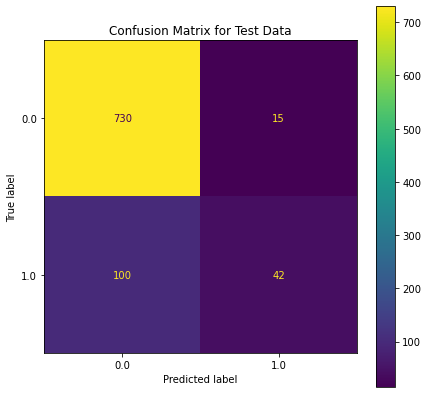

In [39]:
mnb_count1 = Model("MNB Count Vect", mnb_count, count_v, X_train, X_test, y_train, y_test)

In [40]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.845922,1.000000,0.042052,0.080456,0.390047,0.845547,1.000000,0.035211,0.068027,0.427074,0.791436
2,MNB Count Vect,0.846297,0.534513,0.348181,0.420185,0.513858,0.870349,0.736842,0.295775,0.422111,0.555660,0.818650


# Addressing Data Imbalance and Using Ensemble Methods

In [41]:
X_train.head()

6193    rt mention join link start tonight person frie...
4844    head free google sponsor happy hour semantic w...
5452    rt mention apple open quot pop quot store sxsw...
5051    rt mention mention love mention mention sxsw q...
1762    google map usage mobile see demo new version m...
Name: tokens, dtype: object

In [42]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(Xt_tfidf, y_train)

In [43]:
rndm_tfidf = RandomForestClassifier(max_depth=4,random_state=42)
rndm_tfidf.fit(X_res, y_res)

RandomForestClassifier(max_depth=4, random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.4s finished


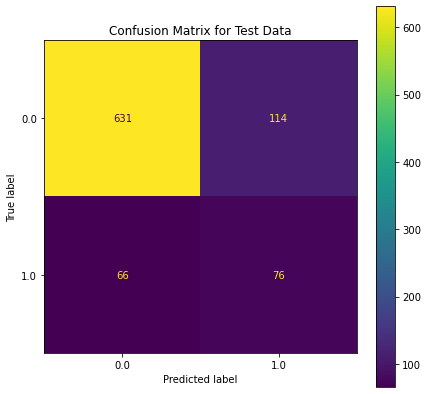

In [44]:
rndm_tfidf1 = Model("RNDM TFIDF Vect", rndm_tfidf, tfidf, X_train, X_test, y_train, y_test)

In [45]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.845922,1.000000,0.042052,0.080456,0.390047,0.845547,1.000000,0.035211,0.068027,0.427074,0.791436
2,MNB Count Vect,0.846297,0.534513,0.348181,0.420185,0.513858,0.870349,0.736842,0.295775,0.422111,0.555660,0.818650
3,RNDM TFIDF Vect,0.839158,0.000000,0.000000,0.000000,0.423910,0.797069,0.400000,0.535211,0.457831,0.644561,0.793137


In [46]:
X_res1, y_res1 = sm.fit_resample(Xt_count, y_train)

In [47]:
rndm_cnt = RandomForestClassifier(random_state=42)
rndm_cnt.fit(X_res1, y_res1)

RandomForestClassifier(random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.3s finished


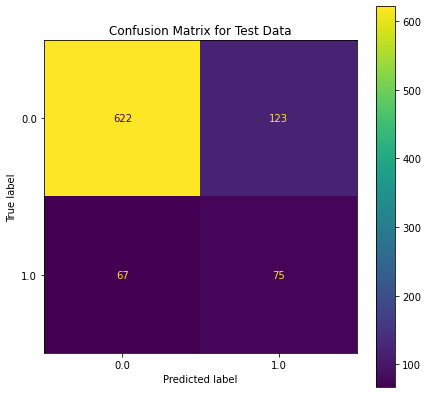

In [48]:
rndm_cnt1 = Model("RNDM Count Vect", rndm_cnt, count_v, X_train, X_test, y_train, y_test)

In [ ]:
Model.model_df

In [50]:
ada_tfidf = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_tfidf.fit(X_res, y_res)

AdaBoostClassifier(n_estimators=100, random_state=42)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished


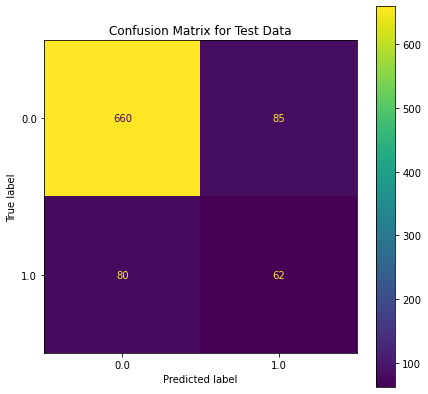

In [51]:
ada_tfidf1 = Model("ADA TFIDF Vect", ada_tfidf, tfidf, X_train, X_test, y_train, y_test)

In [53]:
ada_cnt = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_cnt.fit(X_res1, y_res1)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [ ]:
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


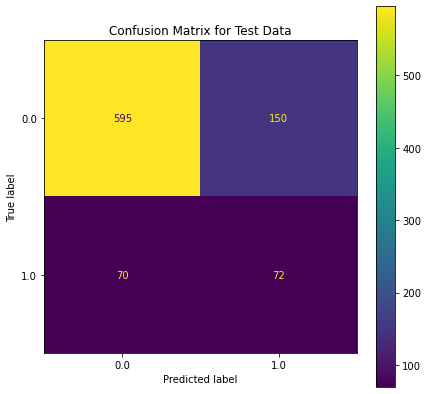

In [54]:
ada_cnt1 = Model("ADA Count Vect", ada_cnt, count_v, X_train, X_test, y_train, y_test)

In [55]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy,0.839158,0.000000,0.000000,0.000000,5.797319,0.839910,0.000000,0.000000,0.000000,5.770235,0.500000
1,Naive Bayes 1,0.845922,1.000000,0.042052,0.080456,0.390047,0.845547,1.000000,0.035211,0.068027,0.427074,0.791436
2,MNB Count Vect,0.846297,0.534513,0.348181,0.420185,0.513858,0.870349,0.736842,0.295775,0.422111,0.555660,0.818650
3,RNDM TFIDF Vect,0.839158,0.000000,0.000000,0.000000,0.423910,0.797069,0.400000,0.535211,0.457831,0.644561,0.793137
4,RNDM Count Vect,0.874859,0.887967,0.254802,0.394184,0.452372,0.785795,0.378788,0.528169,0.441176,0.455471,0.793052
5,ADA TFIDF Vect,0.852683,0.581346,0.299234,0.393806,0.644141,0.813980,0.421769,0.436620,0.429066,0.655214,0.770233
6,ADA Count Vect,0.856442,0.613868,0.310971,0.409139,0.651640,0.751973,0.324324,0.507042,0.395604,0.656395,0.735140
